In [1]:
#Imports
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [2]:
#
num_skipped = 0
for folder_name in ("organic", "recyclable"):
    folder_path = os.path.join("waste_dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


In [3]:
image_size = (128, 128)
batch_size = 64

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "waste_dataset",
    validation_split=0.2,
    subset="both",
    seed=1998,
    image_size=image_size,
    batch_size=batch_size,
)

Found 24705 files belonging to 2 classes.
Using 19764 files for training.
Using 4941 files for validation.


2024-06-04 18:06:04.927357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


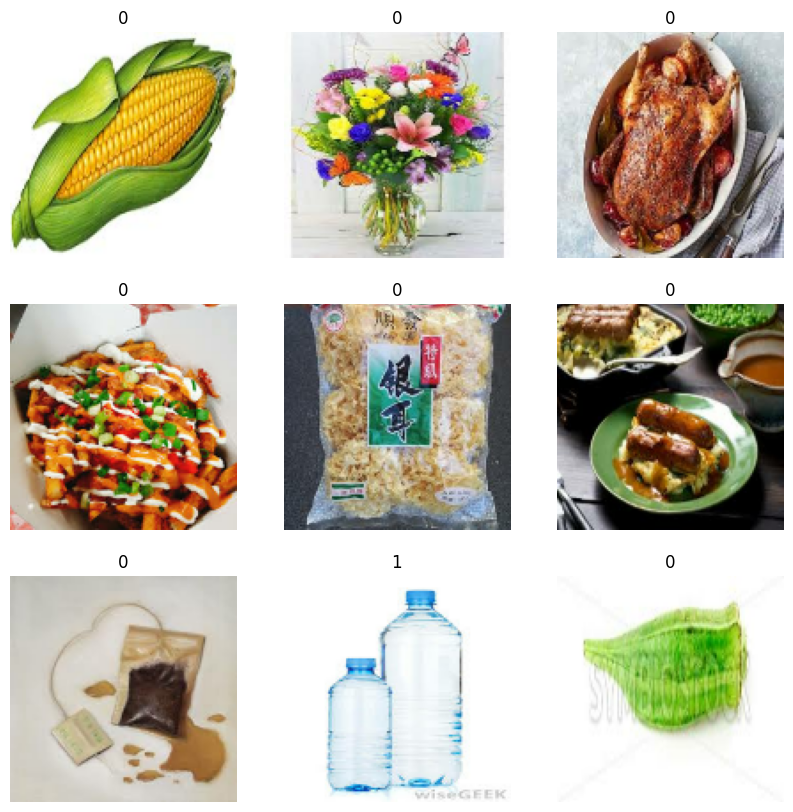

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2024-06-04 18:06:05.592397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


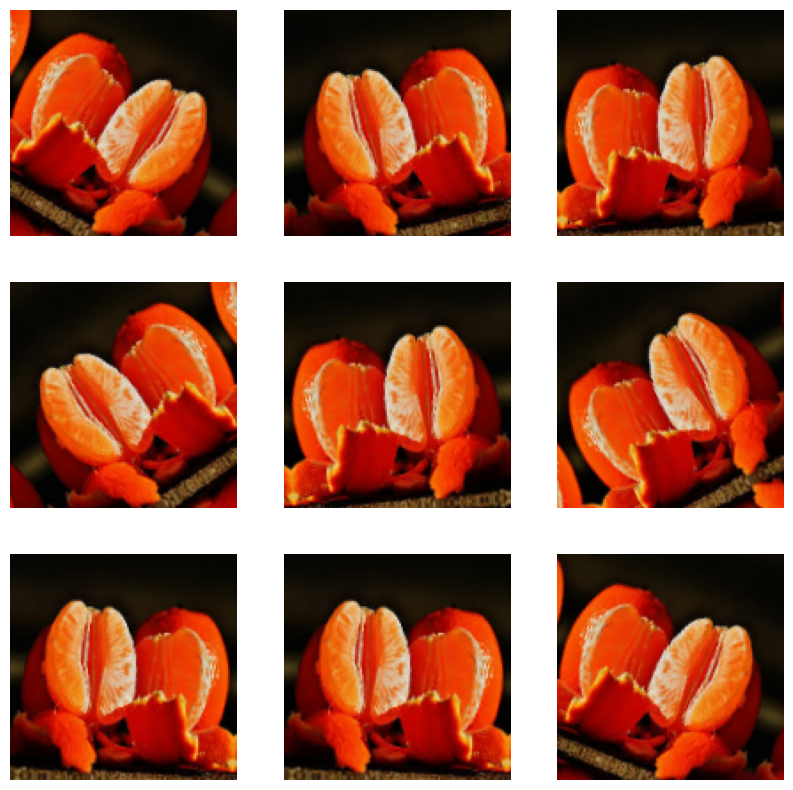

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [7]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [12]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 1164s 4s/step - acc: 0.7928 - loss: 0.4488 - val_acc: 0.4378 - val_loss: 0.8623
Epoch 2/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 2536s 8s/step - acc: 0.8399 - loss: 0.3680 - val_acc: 0.7861 - val_loss: 0.4569
Epoch 3/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 1455s 5s/step - acc: 0.8504 - loss: 0.3466 - val_acc: 0.8512 - val_loss: 0.3528
Epoch 4/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 1537s 5s/step - acc: 0.8592 - loss: 0.3274 - val_acc: 0.8091 - val_loss: 0.5228
Epoch 5/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 2446s 8s/step - acc: 0.8651 - loss: 0.3194 - val_acc: 0.8466 - val_loss: 0.3938
Epoch 6/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 2280s 7s/step - acc: 0.8703 - loss: 0.3086 - val_acc: 0.8472 - val_loss: 0.4009
Epoch 7/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 2638s 9s/step - acc: 0.8762 - loss: 0.2979 - val_acc: 0.8498 - val_loss: 0.4060
Epoch 8/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 1569s 5s/step - acc: 0.8804 - loss: 0.2900 - val_acc: 0.7988 - val_loss: 0.5525
Epoch 9/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
img = keras.utils.load_img("waste_dataset/organic/organic_000001_photo.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% organic and {100 * score:.2f}% recyclable.")